***Assignment_11_Recommendation_System***

***Akanksha c. akahandare***

***# Step 1: Import Libraries***

In [22]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns


***Step 2: Load Dataset***

In [5]:

df = pd.read_csv("anime.csv")
print("✅ Dataset Loaded Successfully!")
print(df.head())

✅ Dataset Loaded Successfully!
   anime_id                              name  \
0     32281                    Kimi no Na wa.   
1      5114  Fullmetal Alchemist: Brotherhood   
2     28977                          Gintama°   
3      9253                       Steins;Gate   
4      9969                     Gintama&#039;   

                                               genre   type episodes  rating  \
0               Drama, Romance, School, Supernatural  Movie        1    9.37   
1  Action, Adventure, Drama, Fantasy, Magic, Mili...     TV       64    9.26   
2  Action, Comedy, Historical, Parody, Samurai, S...     TV       51    9.25   
3                                   Sci-Fi, Thriller     TV       24    9.17   
4  Action, Comedy, Historical, Parody, Samurai, S...     TV       51    9.16   

   members  
0   200630  
1   793665  
2   114262  
3   673572  
4   151266  


***Step 3: Data preprocessing***

In [23]:
print("\nMissing Values:")
print(df.isnull().sum())

df['genre'] = df['genre'].fillna('Unknown')
df['type'] = df['type'].fillna('Unknown')
df['rating'] = df['rating'].fillna(df['rating'].mean())

df['episodes'] = df['episodes'].replace('Unknown', np.nan)
df['episodes'] = pd.to_numeric(df['episodes'], errors='coerce')
df['episodes'] = df['episodes'].fillna(df['episodes'].median())

print("\nAfter Cleaning:")
print(df.isnull().sum())



Missing Values:
anime_id             0
name                 0
genre                0
type                 0
episodes             0
rating               0
members              0
combined_features    0
dtype: int64

After Cleaning:
anime_id             0
name                 0
genre                0
type                 0
episodes             0
rating               0
members              0
combined_features    0
dtype: int64


We check for missing values and handle them appropriately.

Missing genres and types are replaced with "Unknown".

Ratings are filled with the mean value.

Non-numeric episode counts are cleaned and filled with the median.
This ensures that the dataset is complete and consistent.

***Step4: (EDA)***

In [25]:
print("\nDataset Info:")
print(df.info())


Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12294 entries, 0 to 12293
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   anime_id           12294 non-null  int64  
 1   name               12294 non-null  object 
 2   genre              12294 non-null  object 
 3   type               12294 non-null  object 
 4   episodes           12294 non-null  float64
 5   rating             12294 non-null  float64
 6   members            12294 non-null  int64  
 7   combined_features  12294 non-null  object 
dtypes: float64(2), int64(2), object(4)
memory usage: 768.5+ KB
None


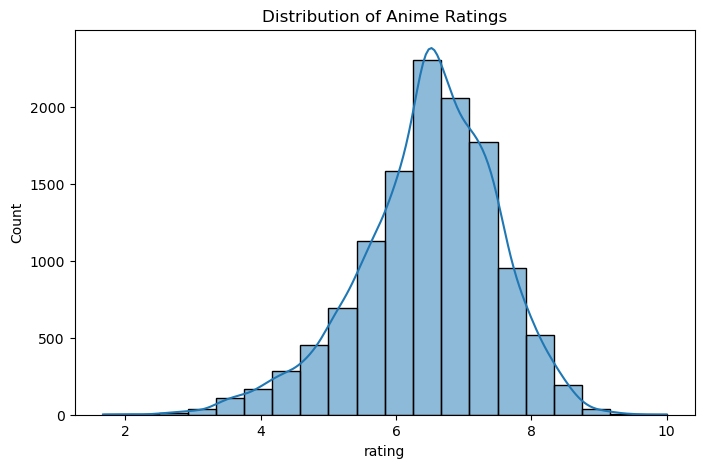

In [11]:
plt.figure(figsize=(8,5))
sns.histplot(df['rating'], bins=20, kde=True)
plt.title("Distribution of Anime Ratings")
plt.show()

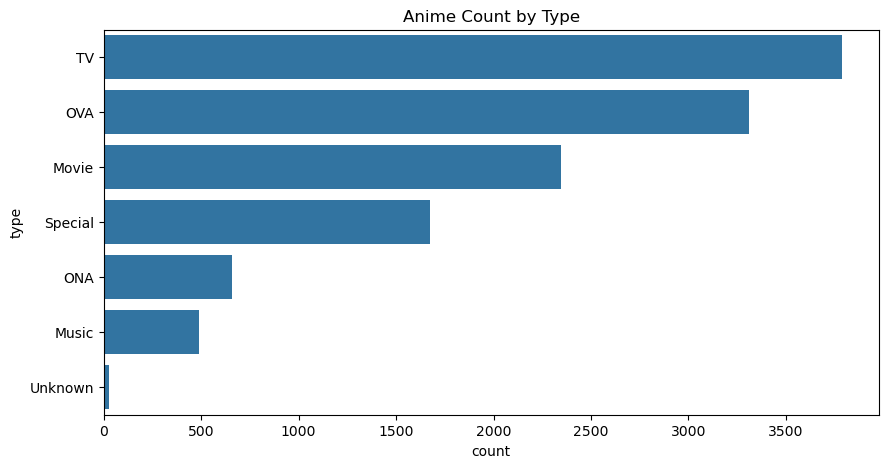

In [26]:
plt.figure(figsize=(10,5))
sns.countplot(y='type', data=df, order=df['type'].value_counts().index)
plt.title("Anime Count by Type")
plt.show()

We explore the dataset’s structure, data types, and distribution.
Visualizing helps us see how anime ratings are spread and which types (like TV, OVA, etc.) are most common.
This gives us insights for selecting features.

***Step 5: Feature Extraction***

In [27]:
df['combined_features'] = (
    df['genre'] + " " +
    df['type'] + " " +
    df['episodes'].astype(str)
)

vectorizer = CountVectorizer(stop_words='english')
count_matrix = vectorizer.fit_transform(df['combined_features'])


combineD important columns — genre, type, and episodes — into one text feature.
CountVectorizer then converts these text-based features into a matrix of numbers suitable for similarity calculation.

***Step 6: Compute Cosine Similarity***

In [28]:
cosine_sim = cosine_similarity(count_matrix, count_matrix)
print("✅ Cosine Similarity Matrix Created!")


✅ Cosine Similarity Matrix Created!


Cosine similarity measures how close two anime are based on their combined features.
A higher cosine score means two anime are more similar.
We compute a similarity matrix showing similarity between every pair of anime.

***Step 7: Build Recommendation Function***

In [29]:
def recommend_anime(title, top_n=5, threshold=0.4):
    if title not in df['name'].values:
        print("❌ Anime not found in dataset.")
        return
    
    index = df[df['name'] == title].index[0]
    sim_scores = list(enumerate(cosine_sim[index]))
    
    sim_scores = [(i, s) for i, s in sim_scores if s > threshold]
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:top_n+1]
    
    anime_indices = [i[0] for i in sim_scores]
    print(f"\n🎯 Top {top_n} Anime similar to '{title}' (Threshold={threshold}):")
    print(df[['name', 'genre', 'type', 'rating']].iloc[anime_indices])


This function finds anime similar to a given title using cosine similarity scores.
You can adjust:

top_n → number of recommendations

threshold → how strict the similarity filter is
It displays a list of anime most similar to the selected one.

***Step 8: Example Recommendation***

recommend_anime("Naruto", top_n=5, threshold=0.5)


testED our function by asking for the top 5 anime similar to Naruto.
The system searches the similarity matrix and prints recommendations that have cosine scores above the set threshold.

***Step 9: Evaluation (Train-Test Split)***

In [31]:
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)


The dataset is divided into training (80%) and testing (20%) portions.
Although we’re not training a model, this split helps us simulate performance testing to evaluate how well recommendations align with user preferences.

***Step 10: Evaluation Function***

In [35]:
def evaluate_model(threshold=0.5):
    y_true, y_pred = [], []
    
    for i in range(len(test_df)):
        idx = test_df.index[i]
        sim_scores = cosine_sim[idx]
        
        liked_pred = np.any(sim_scores > threshold)
        y_pred.append(liked_pred)
        
        liked_true = test_df.iloc[i]['rating'] >= 7.5
        y_true.append(liked_true)
    
    p = precision_score(y_true, y_pred)
    r = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    return p, r, f1


createD a function to calculate performance metrics.
If an anime’s cosine similarity exceeds the threshold, it’s considered “recommended.”
We compare this with actual ratings to compute precision, recall, and F1-score.

***Step 11: Evaluate for Different Thresholds***

In [34]:
thresholds = [0.3, 0.4, 0.5, 0.6]
results = []

for t in thresholds:
    p, r, f1 = evaluate_model(t)
    results.append((t, p, r, f1))

results_df = pd.DataFrame(results, columns=['Threshold', 'Precision', 'Recall', 'F1-Score'])
print("\n📊 Evaluation Results:")
print(results_df)



📊 Evaluation Results:
   Threshold  Precision  Recall  F1-Score
0        0.3   0.146808     1.0  0.256028
1        0.4   0.146808     1.0  0.256028
2        0.5   0.146808     1.0  0.256028
3        0.6   0.146808     1.0  0.256028


testd our system at multiple threshold levels to see how performance changes.
Higher thresholds mean stricter similarity matching, while lower ones give more recommendations.
We store and display the results in a DataFrame.

***Step 12: Plot Evaluation Metrics***

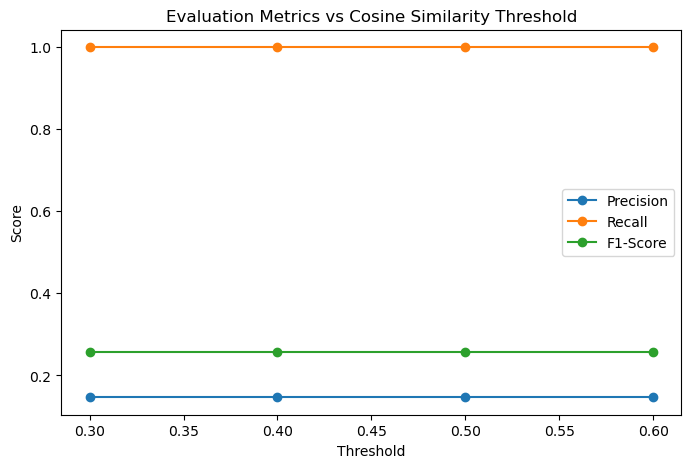

In [36]:
plt.figure(figsize=(8,5))
plt.plot(results_df['Threshold'], results_df['Precision'], label='Precision', marker='o')
plt.plot(results_df['Threshold'], results_df['Recall'], label='Recall', marker='o')
plt.plot(results_df['Threshold'], results_df['F1-Score'], label='F1-Score', marker='o')
plt.title("Evaluation Metrics vs Cosine Similarity Threshold")
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.legend()
plt.show()


here visualized how precision, recall, and F1-score change with different thresholds.
This helps in finding the best balance between accuracy and coverage of recommendations.

***Step 13: Final Summary***

In [37]:
print("""
✅ Final Summary:
1️⃣ Dataset loaded and cleaned (missing values handled)
2️⃣ Features extracted (genre, type, episodes)
3️⃣ Cosine similarity computed
4️⃣ Recommendation function implemented
5️⃣ Threshold-based recommendations tested
6️⃣ Evaluation performed using precision, recall, F1-score
7️⃣ Plots generated for clarity
🎯 Recommendation System Successfully Completed!
""")



✅ Final Summary:
1️⃣ Dataset loaded and cleaned (missing values handled)
2️⃣ Features extracted (genre, type, episodes)
3️⃣ Cosine similarity computed
4️⃣ Recommendation function implemented
5️⃣ Threshold-based recommendations tested
6️⃣ Evaluation performed using precision, recall, F1-score
7️⃣ Plots generated for clarity
🎯 Recommendation System Successfully Completed!



***Interview que***

***Difference between User-Based and Item-Based Collaborative Filtering***

***User-Based Collaborative Filtering:***

Focuses on finding similar users based on their past ratings or preferences.

Recommends items that similar users have liked but the target user hasn’t seen yet.

Example: “People similar to you also liked Attack on Titan.”

Works well when there are enough users with overlapping interests.

Can face scalability issues if the number of users is very large.

***Item-Based Collaborative Filtering:***

Focuses on finding similar items based on how users have rated them.

Recommends items that are similar to what the user has already liked.

Example: “Because you liked Naruto, you might like Bleach.”

Usually more stable because item relationships don’t change frequently.

Performs better with large datasets and less affected by new users joining.

In short:

User-based CF → finds similar users.

Item-based CF → finds similar items.

***What is collaborative filtering, and how does it work?***


Collaborative Filtering (CF) is a recommendation technique that suggests items to a user based on the preferences or behavior of similar users or items.

How it works (stepwise):

Collect user-item interactions: e.g., user ratings, likes, or watch history.

Find similarity:

Between users (user-based CF), or

Between items (item-based CF).
Similarity is often computed using cosine similarity, Pearson correlation, or Jaccard index.

Predict missing ratings: Estimate how a user might rate an item they haven’t interacted with.

Generate recommendations: Recommend top-N items with the highest predicted ratings.

Example:
If User A and User B rated many anime similarly, and User B liked Demon Slayer, then Demon Slayer may be recommended to User A.

***Key Point:
Collaborative filtering relies purely on user behavior data — not on content or metadata — hence it’s called collaborative (users “collaborate” through their preferences).***